In [1]:
from prototype04_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt
import bilby
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from datetime import datetime

In [2]:
# Hemanta's code
# only for freqency domain waveform
# 3 detector case
# zero spin
# let geocent time be fixed
# injection is done in zero noise so geocent time wont matter for a single observing run (O1, O2, O3, O4)
def compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, \
                      psi, phase, geocent_time, ra, dec, duration=16.0, sampling_frequency=4096, \
                      waveform_arguments=  dict(waveform_approximant = "TaylorF2", reference_frequency = 30., \
                                                minimum_frequency = 20) ):
    
    mass_1_, mass_2_, luminosity_distance_, \
    theta_jn_, psi_, phase_, ra_, dec_ = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1), \
                                        np.array([luminosity_distance]).reshape(-1), np.array([theta_jn]).reshape(-1), \
                                        np.array([psi]).reshape(-1), np.array([phase]).reshape(-1), \
                                        np.array([ra]).reshape(-1), np.array([dec]).reshape(-1)
    
    bilby.core.utils.logger.disabled = True
    np.random.seed(88170235)
    nsamples = np.size(mass_1_)
    
    # initialize interferometer object
    # it is ideal to initialized it outside the for loop
    waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration,
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments,)
    
    ifos_ = bilby.gw.detector.InterferometerList(["L1", "H1", "V1"])
    ifos_.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=geocent_time - 2,
    )
    
    opt_snr0 = []
    opt_snr1 = []
    opt_snr2 = []
    # f_max=4096/2  
    for i in range(nsamples):
        ifos = ifos_
        injection_parameters = dict(mass_1=mass_1_[i],mass_2=mass_2_[i],a_1=0.,a_2=0.,tilt_1=0.,tilt_2=0.,phi_12=0.,\
                                    phi_jl=0.,luminosity_distance=luminosity_distance_[i],theta_jn=theta_jn_[i],psi=psi_[i], \
                                    phase=phase_[i],geocent_time=geocent_time,ra=ra_[i],dec=dec_[i])
        ifos.inject_signal(
            waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
        );
        
        opt_snr0.append(ifos[0].meta_data['optimal_SNR'])
        opt_snr1.append(ifos[1].meta_data['optimal_SNR'])
        opt_snr2.append(ifos[2].meta_data['optimal_SNR'])
        
    opt_snr0,opt_snr1,opt_snr2 = np.array(opt_snr0),np.array(opt_snr1),np.array(opt_snr2)
    opt_snr_net = np.sqrt(opt_snr0**2 + opt_snr1**2 + opt_snr2**2)

    return(np.array([opt_snr0, opt_snr1, opt_snr2, opt_snr_net]))

In [3]:
# Otto's code
# Function for computing bilby SNRs
def compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=4.0, sampling_frequency=4096, waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 30., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"]):
    # Set the duration and sampling frequency of the data segment that we're
    # going to inject the signal into
    # Specify the output directory and the name of the simulation.
    bilby.core.utils.logger.disabled = True
    # Set up a random seed for result reproducibility. 
    np.random.seed(88170235)
    # We are going to inject a binary black hole waveform.  We first establish a
    # dictionary of parameters that includes all of the different waveform
    # parameters, including masses of the two black holes (mass_1, mass_2),
    # spins of both black holes (a, tilt, phi), etc.
    injection_parameters = dict(
        mass_1=mass_1,
        mass_2=mass_2,
        a_1=a_1,
        a_2=a_2,
        tilt_1=tilt_1,
        tilt_2=tilt_2,
        phi_12=phi_12,
        phi_jl=phi_jl,
        luminosity_distance=luminosity_distance,
        theta_jn=theta_jn,
        psi=psi,
        phase=phase,
        geocent_time=geocent_time,
        ra=ra,
        dec=dec
    )
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    # the generator will convert all the parameters
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    # Set up interferometers.  In this case we'll use two interferometers
    # (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
    # sensitivity
    ifos = bilby.gw.detector.InterferometerList(list_of_detectors)
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - 2,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
    );
    network_optimal_snr_squared = 0
    for i in range(len(ifos)):
        single_detector_optimal_snr = ifos[i].meta_data['optimal_SNR']
        # Sum in quadrature
        network_optimal_snr_squared = network_optimal_snr_squared + single_detector_optimal_snr**2
    network_optimal_snr = np.sqrt(network_optimal_snr_squared)
    return network_optimal_snr

In [3]:
# without putting constraint on mass_2, so mass_2 can be <1solar_mass 
def interpolation_table(q,iota,mchirp_min, mchirp_max, nsamples, psi=0., phase=0., ra=0., dec=0., geocent_time=1246527184.169434, \
                        waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 30., minimum_frequency = 20)):
    # preferably: nsamples = 200
    mchirp = np.geomspace(mchirp_min, mchirp_max, nsamples)
    mass_1 = (mchirp*(1+q)**(1/5))/q**(3/5)
    mass_2 = mchirp*q**(2/5)*(1+q)**(1/5)
    mtot = mass_1+mass_2
    geocent_time = geocent_time
    luminosity_distance =100.*np.ones(nsamples)
    # geocent_time cannot be array here
    theta_jn, psi, phase, ra, dec = iota*np.ones(nsamples), psi*np.ones(nsamples), \
                                        phase*np.ones(nsamples), ra*np.ones(nsamples), dec*np.ones(nsamples)
    
    opt_snr_unscaled = compute_bilby_snr_(mass_1, mass_2, luminosity_distance, theta_jn, psi, \
                                          phase, geocent_time, ra, dec, duration=16., sampling_frequency=4096, \
                                          waveform_arguments= waveform_arguments)  
    
    A2 = mchirp**(5./6.)
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (Deff2/A2)*opt_snr_unscaled[0]
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (Deff2/A2)*opt_snr_unscaled[1]
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff2 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (Deff2/A2)*opt_snr_unscaled[2]
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,mchirp,L1snr_,H1snr_,V1snr_,net_snr] ))

In [4]:
def scaled_snr_(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.2661468129972
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.0417461038714
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2214.693865936319
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2)
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

# triple fitting (taking care of mass_ratio)

In [6]:
nn = 40
MassRatio = np.geomspace(0.1,1,nn)
print(MassRatio)

[0.1        0.10608184 0.11253356 0.11937766 0.12663802 0.13433993
 0.14251027 0.15117751 0.16037187 0.17012543 0.18047218 0.1914482
 0.20309176 0.21544347 0.22854639 0.2424462  0.25719138 0.27283334
 0.28942661 0.30702906 0.32570207 0.34551073 0.36652412 0.38881552
 0.41246264 0.43754794 0.46415888 0.49238826 0.52233451 0.55410203
 0.58780161 0.62355073 0.66147406 0.70170383 0.7443803  0.78965229
 0.83767764 0.88862382 0.94266846 1.        ]


In [7]:
nsamples = 40
chirp_mass = np.linspace(1,100,nsamples)
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
waveform_argument = dict(waveform_approximant = "IMRPhenomD", reference_frequency = 30., minimum_frequency = 20)

In [8]:
start_time = datetime.now()
nn = 30
MassRatio = np.geomspace(0.1,1,nn)
cs = []
for j in range(nn):
    mass_ratio = MassRatio[j]*np.ones(nsamples)
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
    my_snrs3 = []
    bilby_snrs3 = []
    SNR_ratio = []
    for i in range(nsamples):
        my_snrs_ = scaled_snr_(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i])[5]
        
        bilby_snrs_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                          psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                              waveform_arguments=waveform_argument )[3,0]
        SNR_ratio.append(bilby_snrs_/my_snrs_)
    cs.append(np.array(SNR_ratio))
cs = np.array(cs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:21.163226


* first fit the q=1 case, MassRatio[19]

In [9]:
# chirp_mass vs snr_ratio, cs=(IMRPhenomXPHM_snr_bilby/taylorF2_snrs_fit)
q1_fit = CubicSpline(chirp_mass, cs[-1,:])

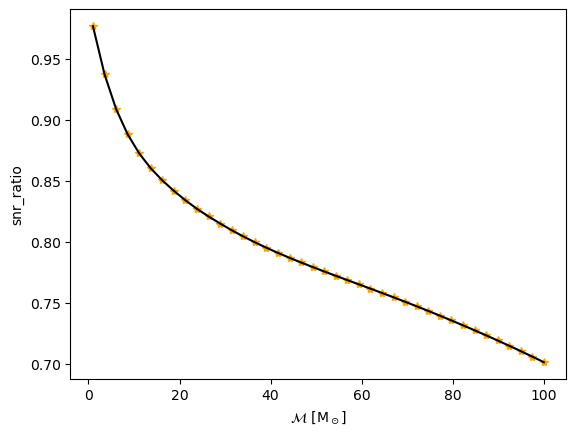

In [10]:
plt.plot(chirp_mass, cs[-1,:], '*', color='orange', label='$q=1$')
plt.plot(chirp_mass, q1_fit(chirp_mass), color='black', label='$\q=1(fit)$')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"snr_ratio")
plt.show()

* now find fit in relation to mass_ratio, in individual chirp_mass point
* there will be 30 cubic spline fit for 30 chirp mass points

In [13]:
param = [] 
x_1 = MassRatio
for ii in range(nsamples):
    
    y_1 = cs[-1,ii]/cs[:,ii]
    param.append(CubicSpline(x_1, y_1))

In [14]:
len(param)

40

In [15]:
chirp_mass[28], chirp_mass[18], chirp_mass[8]

(72.07692307692307, 46.69230769230769, 21.307692307692307)

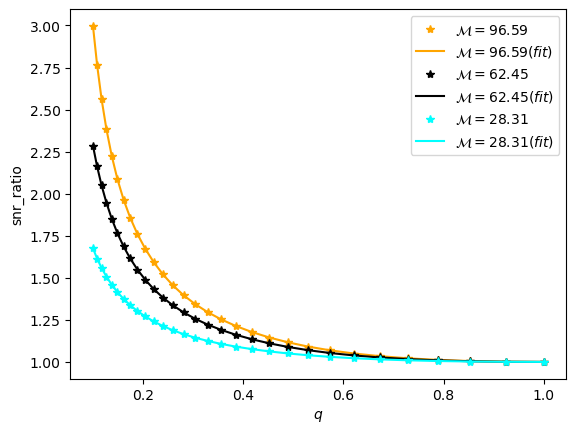

In [16]:
# cs[mass_ratio_idx,chirp_mass_idx]
plt.plot(x_1, cs[-1,28]/cs[:,28], '*', color='orange', label='$\mathcal{M}=96.59$')
plt.plot(x_1, param[28](x_1), color='orange', label='$\mathcal{M}=96.59(fit)$')
plt.plot(x_1, cs[-1,18]/cs[:,18], '*', color='black', label='$\mathcal{M}=62.45$')
plt.plot(x_1, param[18](x_1), color='black', label='$\mathcal{M}=62.45(fit)$')
plt.plot(x_1, cs[-1,8]/cs[:,8], '*', color='cyan', label='$\mathcal{M}=28.31$')
plt.plot(x_1, param[8](x_1), color='cyan', label='$\mathcal{M}=28.31(fit)$')

plt.legend()
plt.rcParams['figure.figsize'] = [20, 10]
plt.xlabel(r"$q$")
plt.ylabel(r"snr_ratio")
plt.show()

# rewrite the scaled_snr_ function to account for model change 
* first test for q=1 case (double scaling)
* then test for q=random case (triple scaling)

In [17]:
def scaled_snr(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec, fits):
    
    chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.2661468129972
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.0417461038714
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2214.693865936319
    
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2) * fits(chirp_mass)
    
    return(np.array( [mtot,chirp_mass,L1snr_,H1snr_,V1snr_,net_snr] ))

In [18]:
nsamples = 30
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = 1.*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [147]:
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], geocent_time[i], ra[i], dec[i], q1_fit)
    my_snrs.append(snr_[5])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.528177


In [148]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs.append(snr_[3,0])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.874537


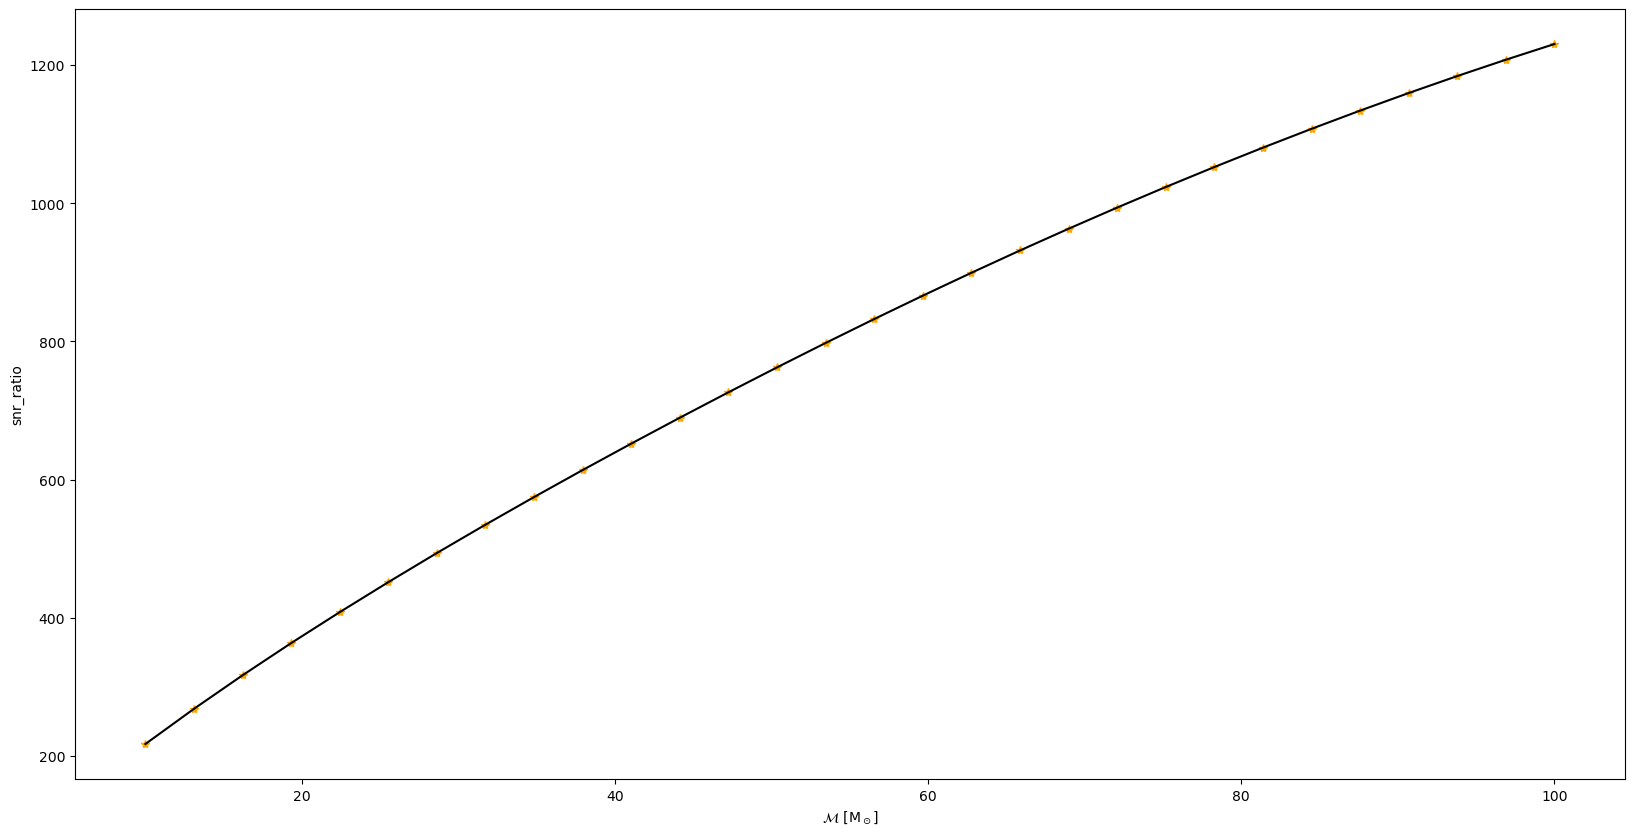

In [149]:
plt.plot(chirp_mass, bilby_snrs, '*', color='orange', label='$q=1$')
plt.plot(chirp_mass, my_snrs, color='black', label='$\q=1(fit)$')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"snr_ratio")
plt.show()

# now taking care of mass_ratio change

In [19]:
def scaled_snr(mass_1, mass_2, iota, Dl, psi, geocent_time, ra, dec, fits, csFits, M_arr):
    
    chirp_mass_ = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
    mtot = mass_2+mass_1
    A1 = chirp_mass_**(5./6.)
    geocent_time = geocent_time
    # snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319]
    # for L1,H1,V1 respectively
    ##############################
    Fp, Fc = Detector('L1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    L1snr_ = (A1/Deff1)*2908.2661468129972
    ##############################
    Fp, Fc = Detector('H1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    H1snr_ =  (A1/Deff1)*2908.0417461038714
    ##############################
    Fp, Fc = Detector('V1').antenna_pattern(ra, dec, psi, geocent_time)
    Deff1 = Dl/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
    V1snr_ =  (A1/Deff1)*2214.693865936319
    
    idx = np.searchsorted(M_arr, chirp_mass_)
    net_snr = np.sqrt(L1snr_**2 + H1snr_**2 + V1snr_**2) * fits(chirp_mass_)/csFits[idx](mass_2/mass_1)
    
    return(np.array( [mtot,chirp_mass_,L1snr_,H1snr_,V1snr_,net_snr] ))

In [130]:
nsamples = 100
chirp_mass = np.linspace(10,90,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [131]:
chirpM = np.linspace(1,100,30)
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], \
                      geocent_time[i], ra[i], dec[i], q1_fit, param, chirpM)
    my_snrs.append(snr_[5])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.315144


In [132]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs.append(snr_[3,0])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:06.719607


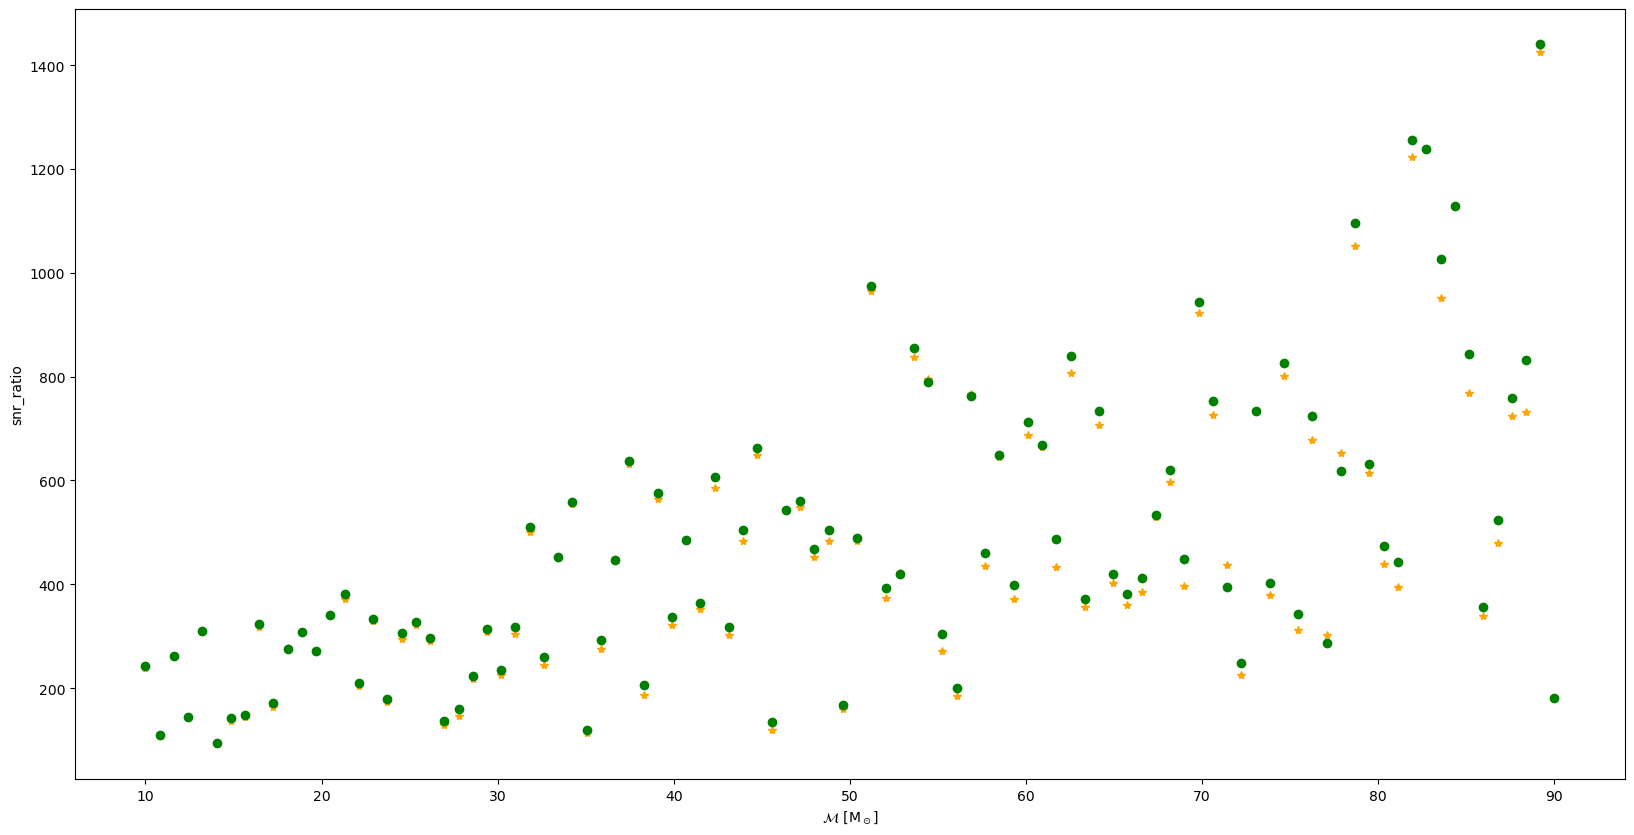

In [133]:
plt.plot(chirp_mass, bilby_snrs, '*', color='orange', label='$q=1$')
plt.plot(chirp_mass, my_snrs, 'o',color='green', label='$\q=1(fit)$')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"snr_ratio")
plt.show()

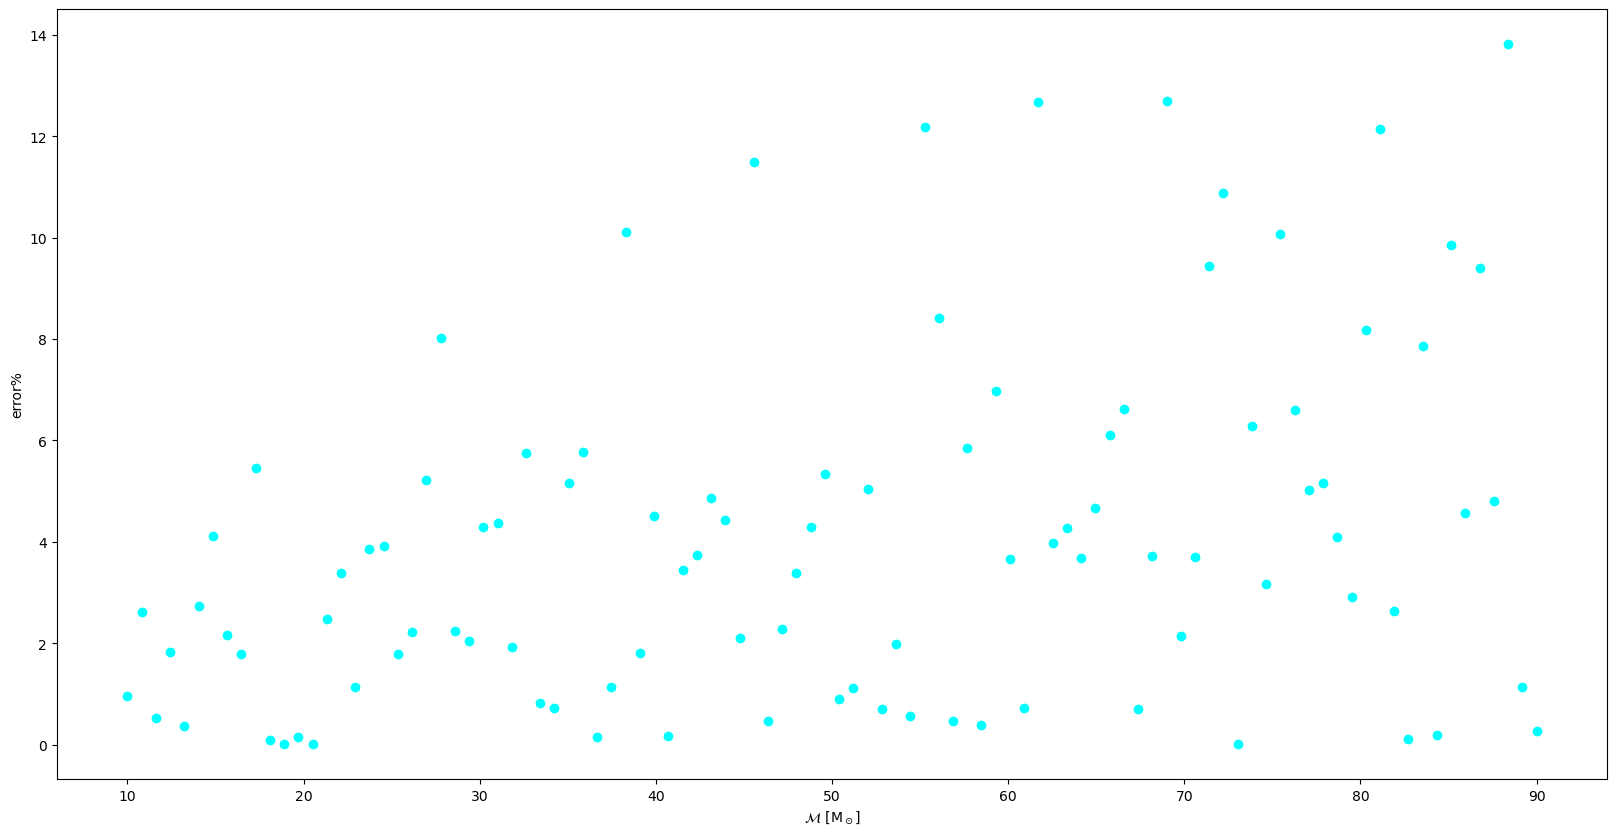

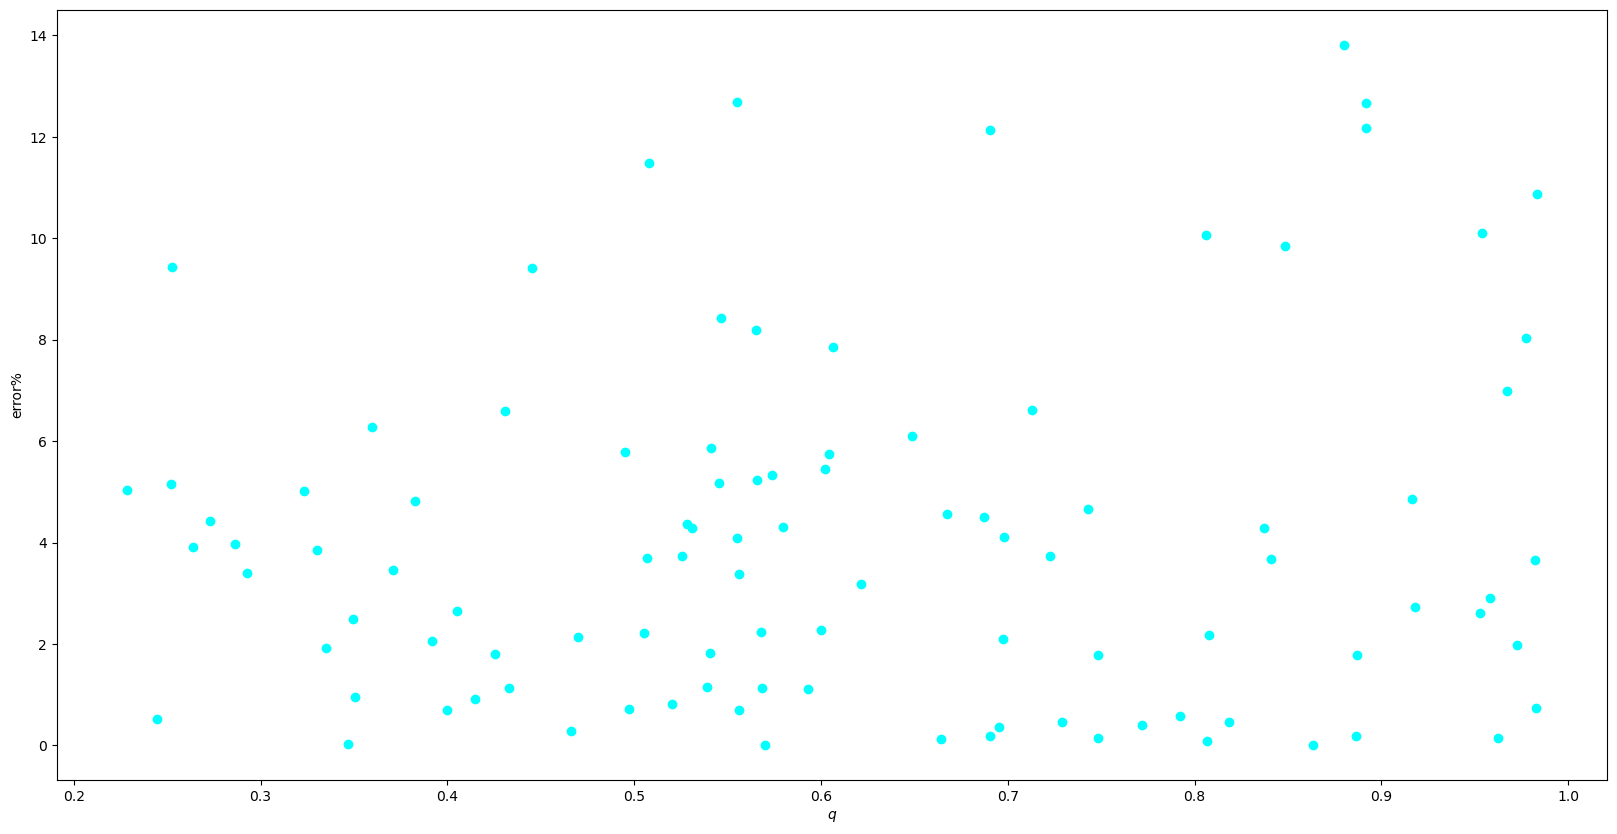

In [135]:
plt.plot(chirp_mass, np.abs(bilby_snrs-my_snrs)/bilby_snrs*100, 'o', color='cyan')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()
plt.plot(mass_ratio, np.abs(bilby_snrs-my_snrs)/bilby_snrs*100, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"error%")
plt.show()

* study the outlier point

In [139]:
idx = np.abs(bilby_snrs-my_snrs)/bilby_snrs*100>13

In [140]:
chirp_mass[idx], mass_ratio[idx]

(array([88.38383838]), array([0.88022433]))

In [141]:
nsamples = 30
chirp_mass = np.linspace(10,90,nsamples)
mass_ratio = 0.20727929*np.ones(nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
theta_jn = 0.*np.ones(nsamples)
geocent_time = 1246527184.169434*np.ones(nsamples)
ra, dec, psi, phase = 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples), 0.*np.ones(nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [33]:
mass_ratio = mass_ratio[idx]

In [142]:
chirpM = np.linspace(1,100,30)
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], \
                      geocent_time[i], ra[i], dec[i], q1_fit, param, chirpM)
    my_snrs.append(snr_[5])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.424293


In [143]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs.append(snr_[3,0])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.942515


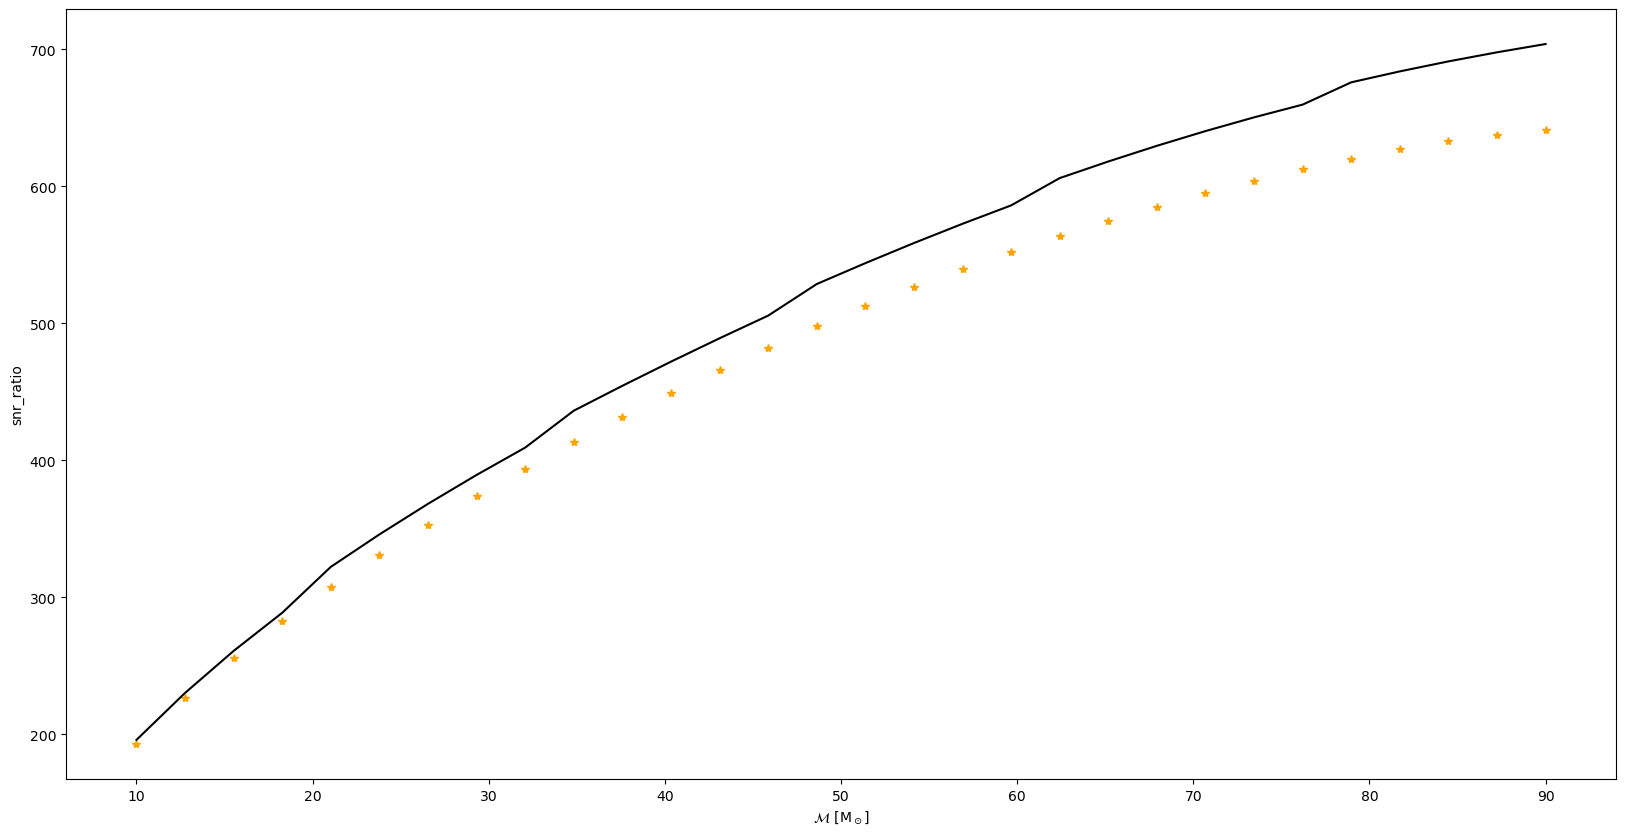

In [144]:
plt.plot(chirp_mass, bilby_snrs, '*', color='orange', label='$q=1$')
plt.plot(chirp_mass, my_snrs, color='black', label='$\q=1(fit)$')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"snr_ratio")
plt.show()

In [152]:
# otto's error
abs(0.75-1)/0.75*100

33.33333333333333

# For BNS only

In [28]:
nsamples = 100
chirp_mass = np.linspace(1,3,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
idx = mass_2>1.
mass_2 = mass_2[idx]
mass_1 = mass_1[idx]
chirp_mass = chirp_mass[idx]
nsamples = len(mass_2)
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [29]:
chirpM = np.linspace(1,100,30)
start_time = datetime.now()
my_snrs = []
for i in range(nsamples):
    snr_ = scaled_snr(mass_1[i], mass_2[i], theta_jn[i], luminosity_distance[i], psi[i], \
                      geocent_time[i], ra[i], dec[i], q1_fit, param, chirpM)
    my_snrs.append(snr_[5])
my_snrs = np.array(my_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:01.213247


In [30]:
start_time = datetime.now()
bilby_snrs = []
for i in range(nsamples):
    snr_ = compute_bilby_snr_(mass_1[i], mass_2[i], luminosity_distance[i], theta_jn[i], \
                      psi[i], phase[i], geocent_time[i], ra[i], dec[i], sampling_frequency=4096, \
                                          waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", \
                                                                                       reference_frequency = 30., \
                                                                                       minimum_frequency = 20))
    bilby_snrs.append(snr_[3,0])
bilby_snrs = np.array(bilby_snrs)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:09.302124


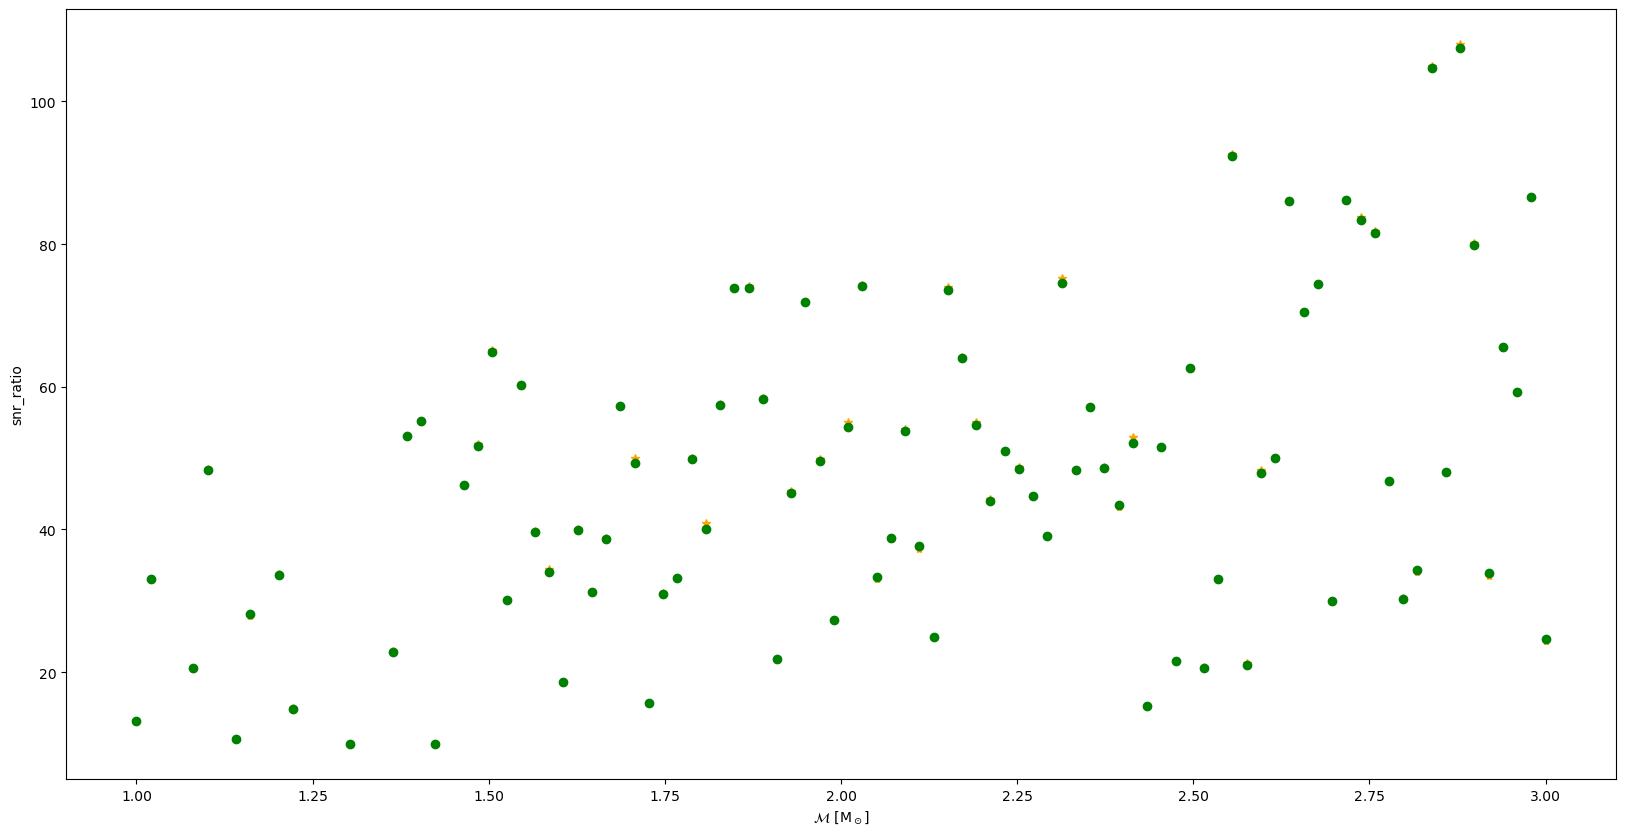

In [31]:
plt.plot(chirp_mass, bilby_snrs, '*', color='orange', label='$q=1$')
plt.plot(chirp_mass, my_snrs, 'o',color='green', label='$\q=1(fit)$')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"snr_ratio")
plt.show()

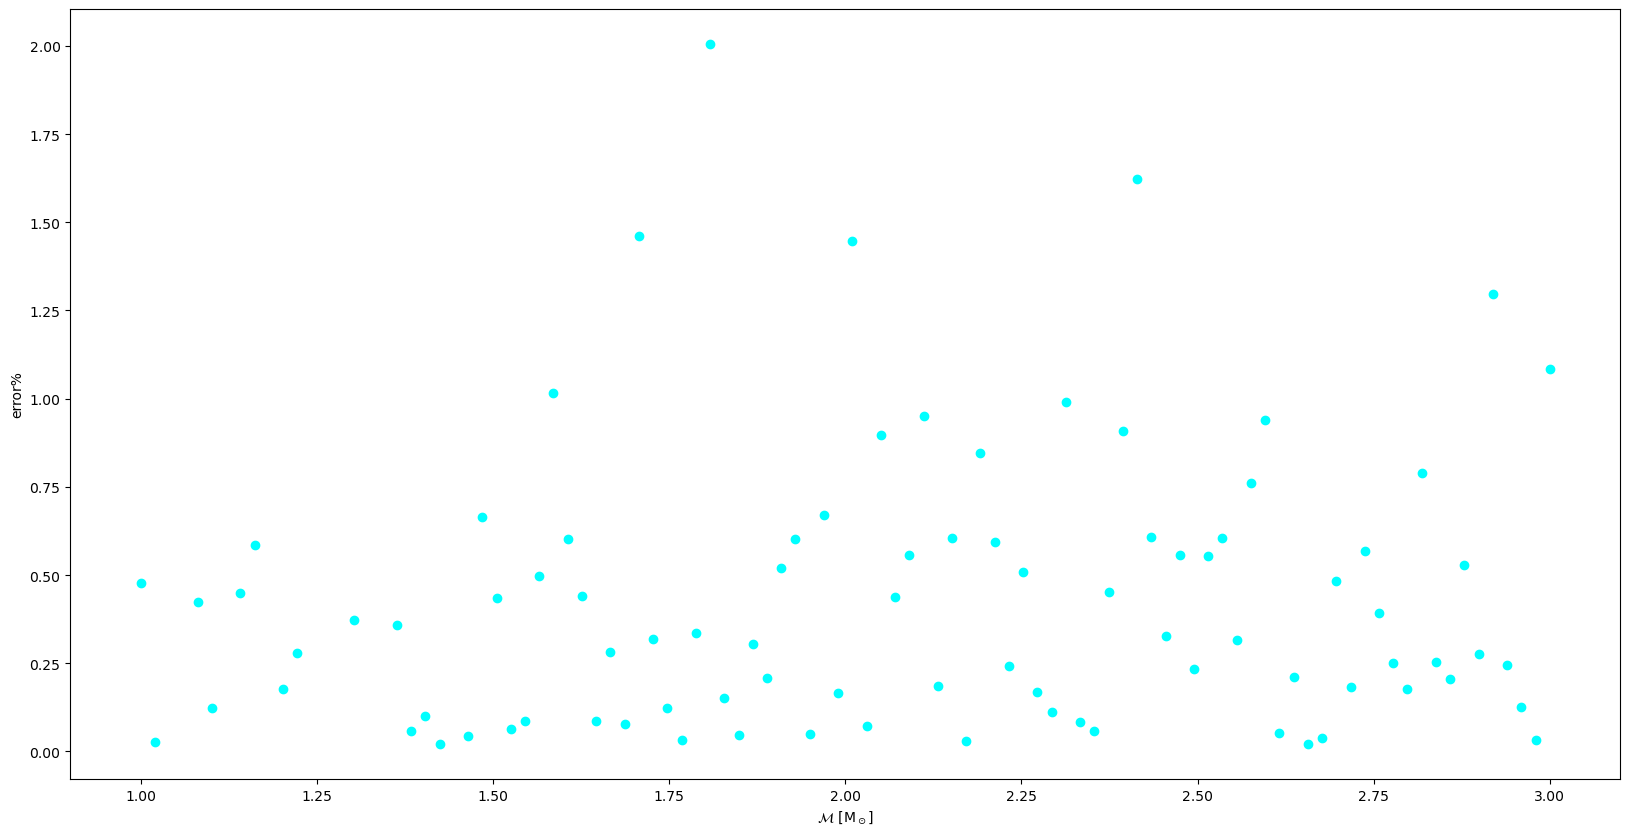

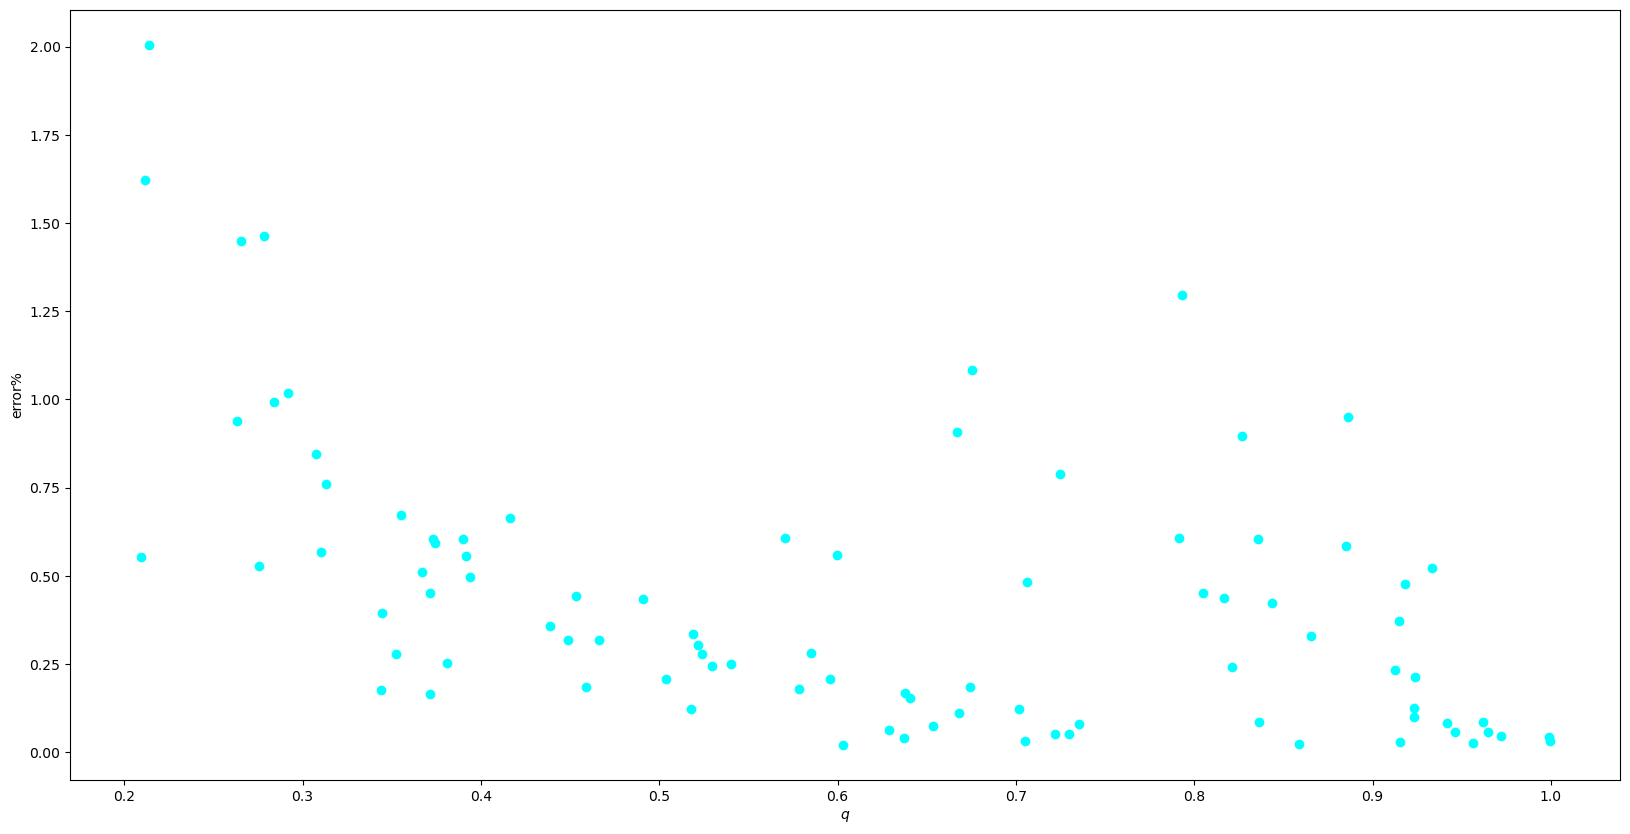

In [34]:
plt.plot(chirp_mass, np.abs(bilby_snrs-my_snrs)/bilby_snrs*100, 'o', color='cyan')
plt.xlabel(r"$\mathcal{M}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()
plt.plot(mass_ratio, np.abs(bilby_snrs-my_snrs)/bilby_snrs*100, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"error%")
plt.show()